In [1]:
# to do: 
# pindah ke path yg bener dan semua files pengikutnya disesuaiin
# numpy yg penting cuman buat arg sort ga si (cuman di fungsi ambil bag berarti?)

#     apus semua path file di folder d di awal launch - check
#     coba pengganti ! (%?) buat di py biasa
#     early stopping callback
#     tambain plot realtime progres eror di to do
    # to do ga masukin readme
    # make the parameters vars customized
    # SEMUA yg panjang2 di main dijadiin function

# file2 tambahan yg perlu diupload juga:
#     bag sensor (?)
#     bagtemp
#     launch file (udah ada harusnya cari lokasinya)
#     folder path
#     YAMLLL

credits to the **YOLO v4 implementation of generic algorithm for hyperparameters tuning** that serves to assist the contributors in understanding the algorithm implementation (and a few lines here and there taken directly and sometimes almost identically from their repo sure were much appreciated!)

**Abel**, **Adam**, and **Gilbert**, who were much help when we at (so many) times faced difficulties in understanding whatever it is of the algorithm we haven't gotten quite the hang yet; thank you."

In [2]:
import numpy as np
import pandas as pd
import rosbag
import os
import yaml
import random
import math as m
from scipy.spatial.distance import cdist
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error

ganti yaml tiap awal generasi

In [3]:
#function for changing the parameter values (YAML file is used for the params to be called from the main UKF program)
def change_params_yaml(p,q):
    with open('/home/win/awin_ws/src/robot_localization/awin/params/ukf_ule_ga_params.yaml') as tes:             
        doc=yaml.safe_load(tes)
    if q is not None:
        doc['process_noise_covariance_Q'] = q
        doc['initial_estimate_covariance_P'] = p
   
    with open('/home/win/awin_ws/src/robot_localization/awin/params/ukf_ule_ga_params.yaml','w') as tes:      #save as
        yaml.safe_dump(doc, tes, indent=2, allow_unicode=False) #dah berhasil ni     

jalanin roslaunch berisi rosbag play, ukf dengan yaml baru untuk setiap generasi, dan rosbag record

In [4]:
# function for launching the 3 nodes: rosbag play back, the ukf algorithm, the recording of the rosbag to a temporary rosbag file that saves the estimation from the UKF
# the ntoebook (with !) and python (with %?) capability to run terminal command is VERY crucial in making this tuning possible in the ROS environment. It was the one thing that was going to be the make or break.
def launch():
    !roslaunch /home/win/awin_ws/src/robot_localization/awin/ukf_ule_ga.launch

jalanin rosbag import cari rmse

In [5]:
def err(est, gt, t_est, t_gt):
    j = 1
    sample_est = []
    sample_gt = []
    for i in range(1, len(t_gt)):
        while (t_gt[i] > t_est[j]):
            j += 1
            
        sample_est.append(est[j])
        sample_gt.append(gt[i])
    rmse=sqrt(mse(sample_gt, sample_est))
    mae=mean_absolute_error(sample_gt, sample_est)
    print("rmse: "+str(rmse)+"\nmae: "+str(mae))
    return rmse,mae

#function for loading the estimation values recorded in the temporary bag file
def ambil_bag():
    bag = rosbag.Bag('ga_temp.bag')
#     print(bag)
    states_xy=[]
    states_xy_baru=[]
    t = []

    for topic, msg, time in bag.read_messages(topics=['/ukf_states']):
        states_xy.append([msg.x,msg.y])
        t.append(msg.stamp.to_sec())
    
    states_xy = np.array(states_xy)
    t = np.array(t)
    
    states_xy = states_xy[np.all(states_xy != 0,axis = 1)] #buang yg 0
    states_xy = states_xy[np.all(~np.isnan(states_xy),axis = 1)] #buang yg nan
    t = t[t != 0]

    utm=[]
    utm_baru=[]
    t_utm = []

    for topic, msg, time in bag.read_messages(topics=['/utm']):
        utm.append([msg.pose.pose.position.x,msg.pose.pose.position.y])
        t_utm.append(time.to_sec())

    utm = np.array(utm)
    t_utm = np.array(t_utm)
    min = utm[0]

    for i in range(len(states_xy)):
        states_xy_baru.append([states_xy[i,0]-min[0],states_xy[i,1]-min[1]])

    states_xy_baru=np.array(states_xy_baru)
    
    for i in range(len(utm)):
        utm_baru.append([utm[i,0]-min[0],utm[i,1]-min[1]])

    utm_baru=np.array(utm_baru)
    return states_xy_baru, utm_baru, t, t_utm

In [6]:
#function for fitness evaluation
def fitness(rmse_groundtruth):
    return 1/rmse_groundtruth

In [7]:
#function for plotting the estimation and the (unextended) GNSS points 
def plot(estimasi,gnss):
    plt.figure(figsize=(10,10))
    matplotlib.style.use('default')

    plt.scatter(estimasi[:,0],estimasi[:,1],s=2.,color='k') #odometry/filtered_map
    plt.scatter(gnss[:,0],gnss[:,1],s=5.,marker="x",c='C3',alpha=1)
    plt.show()

In [8]:
# function for saving the acquired parameter values to an external .txt file
def catat(ptemp,qtemp,errortemp,fitnesstemp,p_path,q_path,error_path,error_bygen_path,fitness_path):
    p = '%14.4g' * len(ptemp) % tuple(ptemp)
    q = '%14.4g' * len(qtemp) % tuple(qtemp)
    error = str(errortemp)
    fitness = str(fitnesstemp)
    
    # adding new information to the temp files
    with open(p_path, 'a') as h:  
        h.write(p + '\n')
    with open(q_path, 'a') as h: 
        h.write(q + '\n')
    with open(error_path, 'a') as h:  
        h.write(error + '\n')
    with open(error_bygen_path, 'a') as h:  
        h.write(error + '\n')
    with open(fitness_path, 'a') as h:  
        h.write(fitness + '\n')
        
    # loading the recently modified temp files nto numpy (for easier sort ith argsort)
    x_q=np.loadtxt(q_path, ndmin=2)  
    x_p=np.loadtxt(p_path, ndmin=2) 
    x_error=np.loadtxt(error_path, ndmin=2)
#     x_error_bygen=np.loadtxt(error_bygen_path, ndmin=2)
    x_fitness=np.loadtxt(fitness_path, ndmin=2)
    
    x_fitness_f=x_fitness.flatten()
    
    # saving the temps but sorted by its corresponding fitness value

    np.savetxt(p_path, x_p[np.argsort(-x_fitness_f)], '%10.5g')
    np.savetxt(q_path, x_q[np.argsort(-x_fitness_f)], '%10.5g')
    np.savetxt(error_path, x_error[np.argsort(-x_fitness_f)], '%10.5g')
#     np.savetxt(error_bygen_path, x_error_bygen, '%10.5g') #savenya berdasarkan error, loadnya berdasarkan fitness
    np.savetxt(fitness_path, x_fitness[np.argsort(-x_fitness_f)], '%10.5g')  #[np.argsortnya ini nambah dimensi]

In [9]:
# delete all files in the path directory before launching
def clear_path(folder):
    os_folder = os.listdir(folder)
    if os_folder:
        for f in os_folder:
            os.remove(os.path.join(folder, f))
        print("Parameters' path is cleared!")
    else:
        print("Parameters' path is already clear!")

In [10]:
def init_pq(p_diag, q_diag):
    p, q = [[0,]*25]*2
    for i,j in enumerate(range(0,25,6)):
        p[j], q[j] = p_diag[i], q_diag[i]
    return p, q

In [11]:
to_load = ['12','asdsad'] + ['fitness']
to_load
for load in to_load:
    print(load)

12
asdsad
fitness


In [13]:
def load_from_path(to_load):
    vars = {}
    for load in to_load:
        vars[load] = np.loadtxt(path[load], ndmin=2)
    return vars

In [14]:
path

NameError: name 'path' is not defined

Parameters' path is cleared!
----------------------------------------------------------------------------------------------------
Generasi ke-1 dari 1000
... logging to /home/win/.ros/log/81f00600-9f3c-11eb-bd8b-f0038c0a96db/roslaunch-win-ubuntu-32723.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
Done checking log file disk usage. Usage is <1GB.
]2;/home/win/awin_ws/src/robot_localization/awin/ukf_ule_ga.launch
started roslaunch server http://win-ubuntu:37119/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [10, 0, 0, 0, 0, ...
 * /kappa: -0.94149010276
 * /process_noise_covariance_Q: [10, 0, 0, 0, 0, ...
 * /rosdistro: melodic
 * /rosversion: 1.14.4

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_ule (golfi/ukf_localization_2d)
    utm (gps_common/utm_odometry_node)



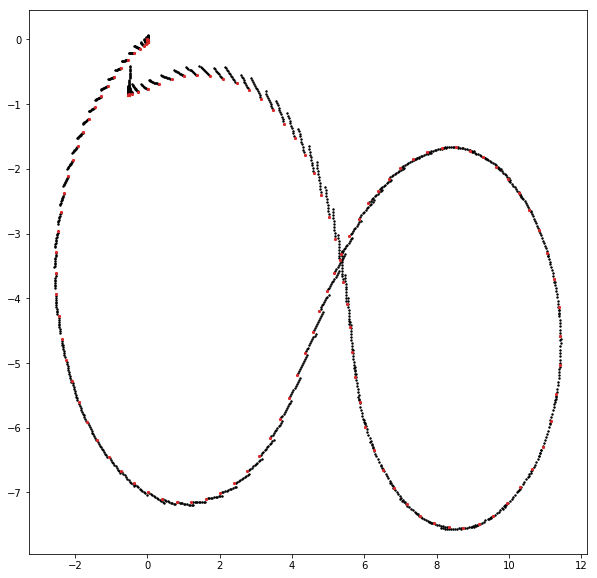

----------------------------------------------------------------------------------------------------
Generasi ke-2 dari 1000


NameError: name 'oiyaa' is not defined

In [15]:
# initializing the parameter values
p_diagonals = [10, 10, 10, 10, 1]
q_diagonals = [10, 10, 10, 10, 1]
p_temp, q_temp = init_pq(p_diagonals, q_diagonals)

# define the max number of generations
temp_folder = "/home/win/ga/path_GA/ga_tila/"
clear_path(temp_folder)

params = ['p', 'q']
errors_saved = ['error', 'error_bygen']
temp_names = params + ['fitness'] + errors_saved
to_load = params + ['fitness']

# defining the filename for the values temps to be saved with
path = {}
for temp in temp_names:
    path[temp] = temp_folder + temp + '_path.txt'

generasi = 1000
for g in range(1, generasi+1):
    print("----------------------------------------------------------------------------------------------------")
    print("Generasi ke-"+ str(g) + " dari " + str(generasi))

    if os.path.exists(path['p']): # load the saved parameters after the 1st generation
        p = np.loadtxt(path['p'], ndmin=2)
        q = np.loadtxt(path['q'], ndmin=2)
        fitness = np.loadtxt(path['fitness'], ndmin=2)
        
       
        # backbone of GA under here
        var = load_from_path(to_load)
        p,q,fitness = var['p'],var['q'],var['fitness']
        #selection
        oiyaa
        n = min(25, len(p)) #defining the max number of the individuals in the population
        
        batas_bawah=1e-03
        daftar_parameter= [p[0],q[0]] #saving the (best?) parameters in p and q as an array
        
        #crossover (recombination of values)
        if g > 2: #picking the parents for the crossover
            indeks_ortu1,indeks_ortu2=random.sample(range(0, n), 2)
            p_ortu=p[[indeks_ortu1,indeks_ortu2],:]
            q_ortu=q[[indeks_ortu1,indeks_ortu2],:]
            fitness_ortu=fitness[[indeks_ortu1,indeks_ortu2],:]
            
            w1=fitness_ortu[0]/(fitness_ortu[0]+fitness_ortu[1])
            p, q = np.ones(25), np.ones(25)

            for j in range(25):
                pilih_ortu_p,pilih_ortu_q=np.random.random(),np.random.random()
                p[j]=(pilih_ortu_p<=w1)*p_ortu[0,j]+(pilih_ortu_p>w1)*p_ortu[1,j]
                q[j]=(pilih_ortu_q<=w1)*q_ortu[0,j]+(pilih_ortu_q>w1)*q_ortu[1,j]

        #mutation
        mp, s=0.8, 6 #mutation probability and the multiplying factor defined
        if g < 25: #the initial population number defined here
            mp,s=1,10 #for initial population, mutation is used to randomly pick the values around the inital values defines before
        penjumlah=[]
        
        apakah_mutasi=np.random.random()
        # condition of mutation existing
        if apakah_mutasi<mp: 
            for a in range(10):
                penjumlah.append((np.random.normal(0,1))) 
        # condition of mutation not existing
        else:
            penjumlah=np.zeros(10) #no addition for mutation
        
        m_p, m_q=np.zeros(25), np.zeros(25)

        i=0
        for b in range(0,25,6):
            m_p[b]=penjumlah[i]
            i+=1
        for c in range(0,25,6):
            m_q[c]=penjumlah[i]
            i+=1
            
        p_temp = (p+m_p).flatten().tolist()
        q_temp = (q+m_q).flatten().tolist()
        
        print("Matriks P generasi ke-"+str(g+1)+": "+str(np.matrix(p_temp)))
        for b in range(0,25,6):
            if p_temp[b]<batas_bawah:
                p_temp[b]=batas_bawah
                
        print("Matriks Q generasi ke-"+str(g+1)+": "+str(np.matrix(q_temp)))
        for c in range(0,25,6): #dibuat supaya q yaw tidak berubah
            if q_temp[c]<batas_bawah:
                q_temp[c]=batas_bawah
            
    #change the value of the parameter with the ones just acquired
    change_params_yaml(p_temp,q_temp)
    
    #run the launch function
    launch()
    
    # acquiring the fitness value by taking the estimation value from the temporary bag file (ga_temp.bag) and find the fitness from the error defined before
    hasil_ukf, utm, t_state, t_utm = ambil_bag()

    er_rmse, er_mae = err(hasil_ukf, utm, t_state, t_utm)
    fit = 1/er_rmse
    
    #plot the estimation for every set of parameter values acquired
    plot(hasil_ukf,utm)
    
    #saving the parameter values acquired
    catat(p_temp,q_temp,er_rmse,fit,path['p'],path['q'],path['error'],
          path['error_bygen'],path['fitness'])

In [ ]:
print("Matriks P generasi ke-"+str(g)+": ")

In [ ]:
fit